# Exploring the Dinosaur Data

In [1]:
import numpy as np
import cv2 as cv
import os
from PIL import Image
import pyautogui
from pathlib import Path
from typing import List

# Getting the Modeling Data

In [2]:
target_address = os.path.join(Path(os.getcwd()).parent,'Window_capture\\Data\\command_keys.npy')
targets = np.load(target_address)
print("Command Keys Shape: ",targets.shape)
screenshot_address = os.path.join(Path(os.getcwd()).parent,'Window_capture\\Data\\screenshots.npy')
screenshot_data = np.load(screenshot_address, allow_pickle=True)
print("Screenshot Shape: ",screenshot_data.shape)

Command Keys Shape:  (4177,)
Screenshot Shape:  (4177,)


# Frequency of data?

In [3]:
# 32 : Space, 38 : Up Arrow Key, 40 Down Arrow Key
print("Command Key Frequency", np.unique(targets, return_counts=True)) 

Command Key Frequency (array([32, 38, 40]), array([  50, 3437,  690], dtype=int64))


# What does one of our screenshots look like?

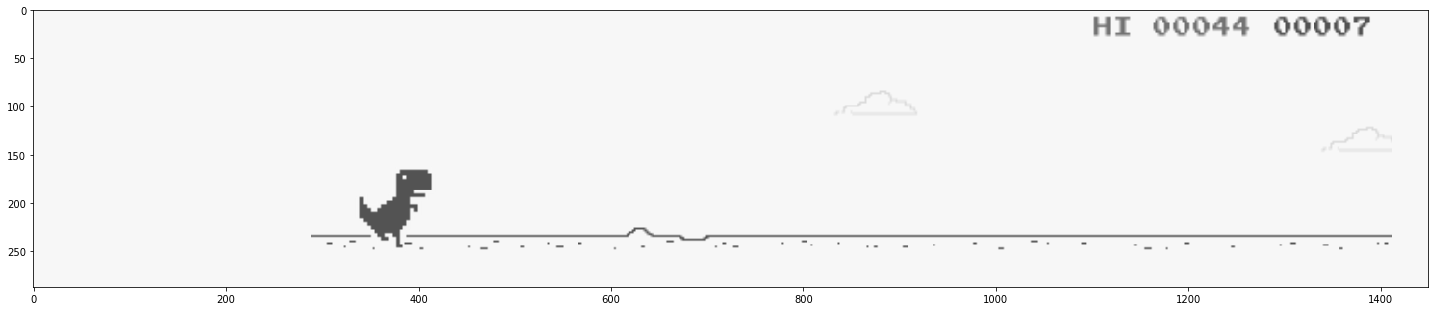

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]
one_pic = screenshot_data[0] # Get the first image
plt.imshow(one_pic, interpolation='nearest')
plt.show()

# Greyscale our Screenshot Data to Prepare for Edge Detection

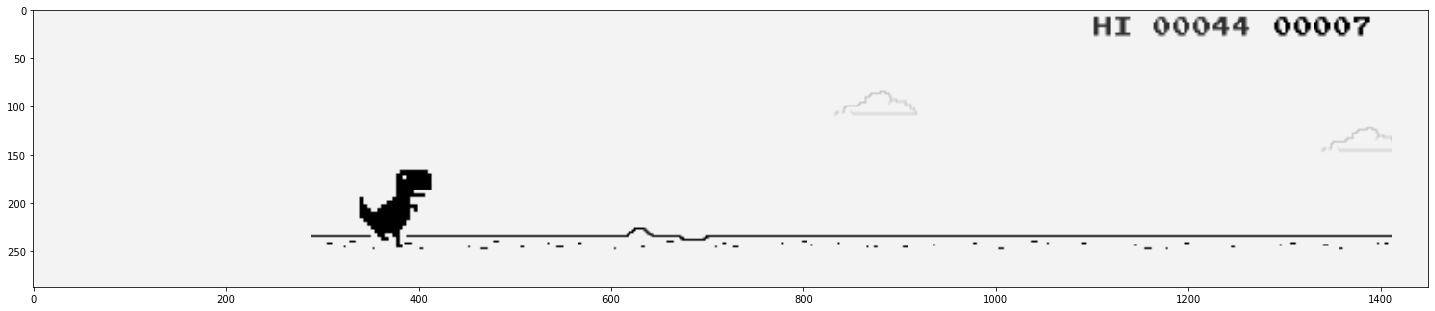

In [5]:
'''We know that color here is not an important factor. Greyscale is especially useful when we want to simplify computational
requirements. '''
gray_pic = cv.cvtColor(one_pic,cv.COLOR_BGR2GRAY)
plt.imshow(gray_pic, cmap='gray',interpolation='nearest')
plt.show()

In [6]:
gray_pic.shape # Notice that the dimensions for a photo are 2-D.

(288, 1450)

In [7]:
def npy_2_greyscale(data: np.ndarray) -> List[int]:
    '''Gray scales screen shot images from BGR->Gray'''
    gray = []
    for img in data:
        gray.append(cv.cvtColor(img,cv.COLOR_BGR2GRAY))
    return gray

Dimensions of the first image: (288, 1450)


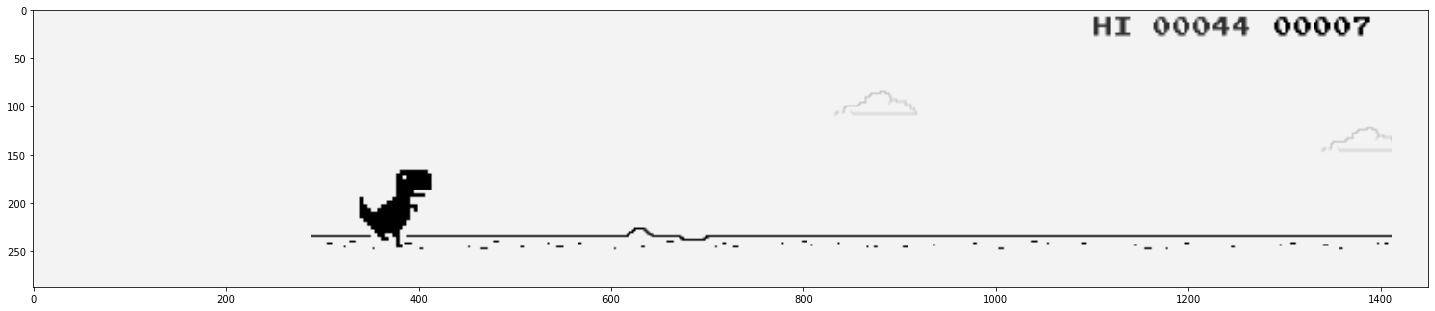

In [8]:
gray_images = npy_2_greyscale(screenshot_data)
print('Dimensions of the first image:',gray_images[0].shape) # Dimensions of first image.
plt.imshow(gray_images[0], cmap='gray',interpolation='nearest')
plt.show() # Exactly the same as the previous image.

In [ ]:
# Now that we have grey scale, let's commence with the Edge detections. 
# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

### Skip to the bottom of notebook to see canny edge detection in action.
# Canny Edge Detection 
- Most commonly used in industry and quite effective
- Multi stage edge detector.

I'll be going through each step of the canny edge detection (but can be applied with a function via cv.Canny)

# 1) Blur Images (Noise Reduction) --> Gaussian Filter
- Blur image to average rapid changes in pixel intensity.
- This will remove outlier pixels that may be considered "noise" in the image.
- Reduces Image detail.

In [ ]:
blurred_gray_image = cv.GaussianBlur(gray_images[0], (5,5), cv.BORDER_DEFAULT )
plt.imshow(blurred_gray_image, cmap='gray',interpolation='nearest')
plt.show() # Exactly the same as the previous image.

In [ ]:
'''Applying Gausian Blur to all Greyscale images.'''
def gauss_blur(data: np.ndarray) -> List[int]:
    blur = []
    for img in data:
        blur.append(cv.GaussianBlur(img, (5,5), cv.BORDER_DEFAULT ))
    return blur

In [ ]:
gray_blur_images = gauss_blur(gray_images)

In [ ]:
# Switching from the first image to the 7th to get more objects in view.
plt.imshow(gray_blur_images[7], cmap='gray',interpolation='nearest')
plt.show() # Exactly the same as the previous image.

# 2) Finding the Intensity Gradient of the Image

In [ ]:
grad_x = cv.Sobel(gray_blur_images[7], cv.CV_64F, 1, 0, ksize=3)
grad_y = cv.Sobel(gray_blur_images[7], cv.CV_64F, 0, 1, ksize=3)

abs_grad_x = cv.convertScaleAbs(grad_x)
abs_grad_y = cv.convertScaleAbs(grad_y)

grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0) # adds grad_x and grad_y

In [ ]:
cv.imshow('grad X',grad_x)
cv.waitKey(0)
cv.destroyWindow('grad X')

In [ ]:
cv.imshow('grad Y',grad_y)
cv.waitKey(0)
cv.destroyWindow('grad Y')

In [ ]:
'''Notice how the edges are quite thick. We want the edges to be thin edges. The reason thick edges are not wanted is that 
they might be perceived as double edges. We will have to use non-maximum suppression to filter the super-thin edges and
thin the thicker edges.'''
cv.imshow('grad',grad) # We will use this.
cv.waitKey(0)
cv.destroyWindow('grad')

In [ ]:
def sobel_weightage(data: np.ndarray) -> List[int]:
    '''First, apply the added weightage to each of the images. *NOTE THAT CANNY EDGE USES A DIFFERENT PROCESS'''
    sobel_weight = []
    for image in data:
        grad_x = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3)
        grad_y = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)
        abs_grad_x = cv.convertScaleAbs(grad_x)
        abs_grad_y = cv.convertScaleAbs(grad_y)
        sobel_weight.append(cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)) # adds grad_x and grad_y
    return sobel_weight

In [ ]:
sob_arr = sobel_weightage(gray_blur_images)

In [ ]:
cv.imshow('grad_0',sob_arr[7]) # We will use this.
cv.waitKey(0)
cv.destroyWindow('grad_0')

In [ ]:
'''Functions used for Canny Edge Detection...
Github where code came from: https://github.com/sebasvega95/Canny-edge-detector/tree/02249a699902bbb1aa548e4653d974573f9f10e3'''
from numpy import array, zeros, abs, sqrt, arctan2, arctan, pi, real
from numpy.fft import fft2, ifft2
from PIL import Image
from matplotlib.pyplot import imshow, show, subplot, figure, gray, title, axis

def gaussian(im):
    b = array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;
    kernel = zeros(im.shape)
    kernel[:b.shape[0], :b.shape[1]] = b

    fim = fft2(im)
    fkernel = fft2(kernel)
    fil_im = ifft2(fim * fkernel)

    return abs(fil_im).astype(int)

def gradient(im):
    # Sobel operator
    op1 = array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]])
    op2 = array([[-1, -2, -1],
                 [ 0,  0,  0],
                 [ 1,  2,  1]])
    kernel1 = zeros(im.shape)
    kernel1[:op1.shape[0], :op1.shape[1]] = op1
    kernel1 = fft2(kernel1)

    kernel2 = zeros(im.shape)
    kernel2[:op2.shape[0], :op2.shape[1]] = op2
    kernel2 = fft2(kernel2)

    fim = fft2(im)
    Gx = real(ifft2(kernel1 * fim)).astype(float)
    Gy = real(ifft2(kernel2 * fim)).astype(float)

    G = sqrt(Gx**2 + Gy**2)
    Theta = arctan2(Gy, Gx) * 180 / pi
    return G, Theta

#####################################################################
gim = gaussian(gray_blur_images[7])
grim, gphase = gradient(gim)
subplot(2, 2, 1)
imshow(im, cmap='gray')
axis('off')
title('Original')

subplot(2, 2, 2)
imshow(gim, cmap='gray')
axis('off')
title('Gaussian')

subplot(2, 2, 3)
imshow(grim, cmap='gray')
axis('off')
title('Gradient')

This was a high level overview for the beginning steps of the Canny Edge Detection. More information can be checked out here: [Raw Code associated with Canny Edge Detection](https://github.com/FienSoP/canny_edge_detector/blob/master/canny_edge_detector.py)
and 
[Detailed blog on Canny Edge Detection](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123)
and [Wiki on Canny Edge Detection](https://en.wikipedia.org/wiki/Canny_edge_detector)

## Further steps done for Canny Edge Detection (Summary included)
---
# Non-Maximum Suppression
- Obtains thin edges (edge thinning technique)
- Finds the pixels with the maximum value in the edge directions

# Double Threshold
- Filter out edge pixels by weak and high gradient values to preserve edge structure.
- If pixel value > threshold value, then pixel value is marked as strong. Vice versa for low pixel values.
- Thresholds are predetermined. A given threshold can be 0.075 for example. (Pixelated values)

# Edge Tracking by Hysteresis
- Determines from the Double Threshold which pixels should be maintained. It does this by a n x n matrix. If there is a strong pixel in the surface area, then the weak point will be preserved. Else, the weak point(s) will be removed.

In [ ]:
'''Thresholds can be tuned. But, they are can be something between 25% and 50% of the second threshold. '''
edge_im = cv.Canny(gray_images[7], threshold1 = 100, threshold2 = 200)
cv.imshow('Canny Image',edge_im) # We will use this.
cv.waitKey(0)
cv.destroyWindow('Canny Image')

# Running Canny on all Gray Scaled Images.

In [9]:
def canny_images(data: np.ndarray) -> List[int]:
    '''Gray scales screen shot images from BGR->Gray
    data: Gray scaled images.'''
    canny_arr = []
    for img in data:
        canny_arr.append(cv.Canny(img, threshold1 = 100, threshold2 = 200))
    return canny_arr

In [10]:
type(gray_images[0])

numpy.ndarray

In [11]:
c_imgs = canny_images(gray_images)
# print('Dimensions of the first image:',gray_images[0].shape) # Dimensions of first image.
# plt.imshow(gray_images[0], cmap='gray',interpolation='nearest')
# plt.show() # Exactly the same as the previous image.

In [12]:
edge_im = cv.Canny(c_imgs[10], threshold1 = 100, threshold2 = 200)
cv.imshow('Canny Image',edge_im) # We will use this.
cv.waitKey(0)
cv.destroyWindow('Canny Image')

In [13]:
np.save('cleaned_data.npy', c_imgs)

c:\users\spenc\anaconda3\envs\cv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
